θ = 0.0: порядок по x = 2.00, порядок по t = 1.00
θ = 0.5: порядок по x = 2.01, порядок по t = 2.01
θ = 1.0: порядок по x = 1.76, порядок по t = 1.05


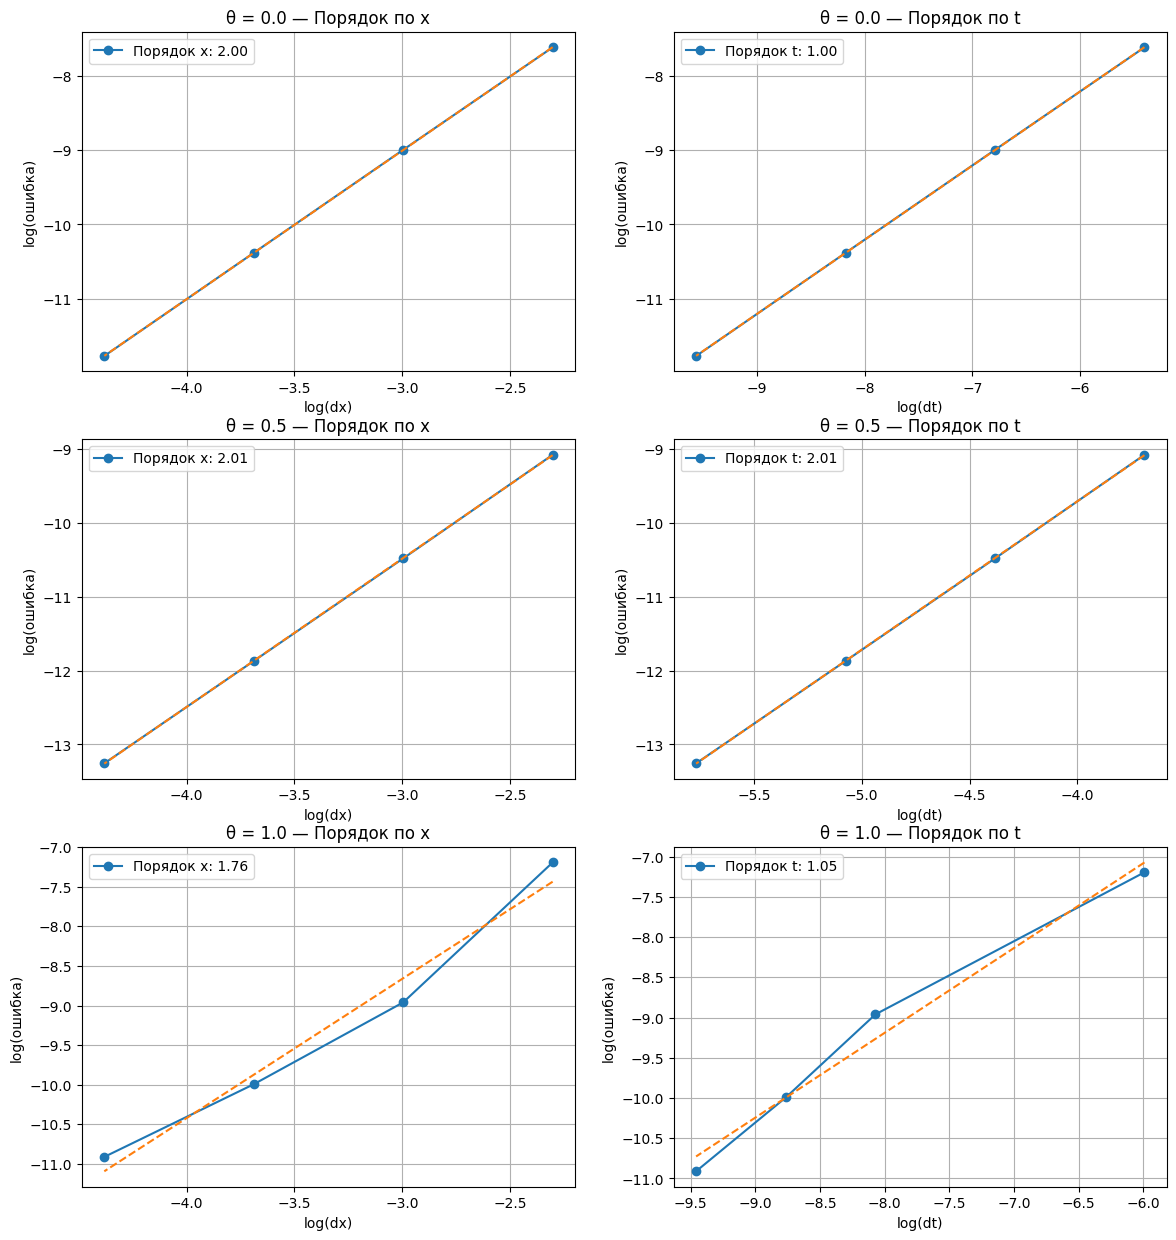

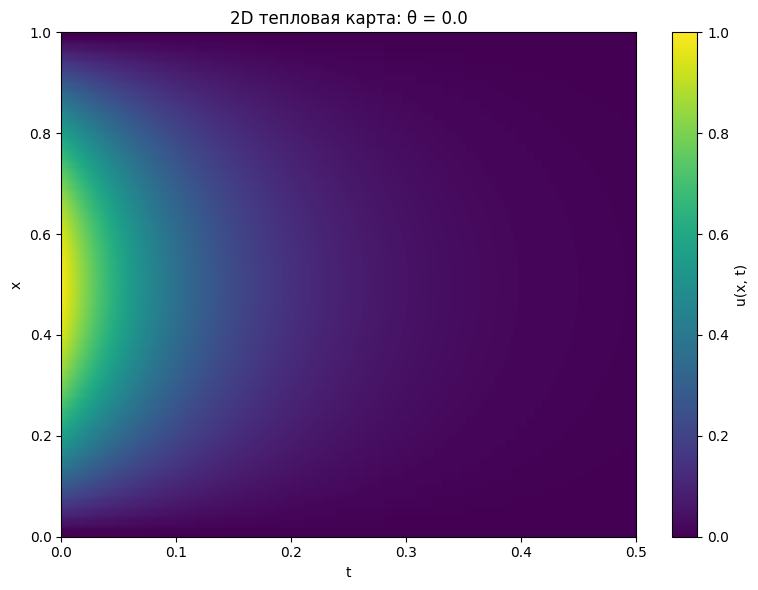

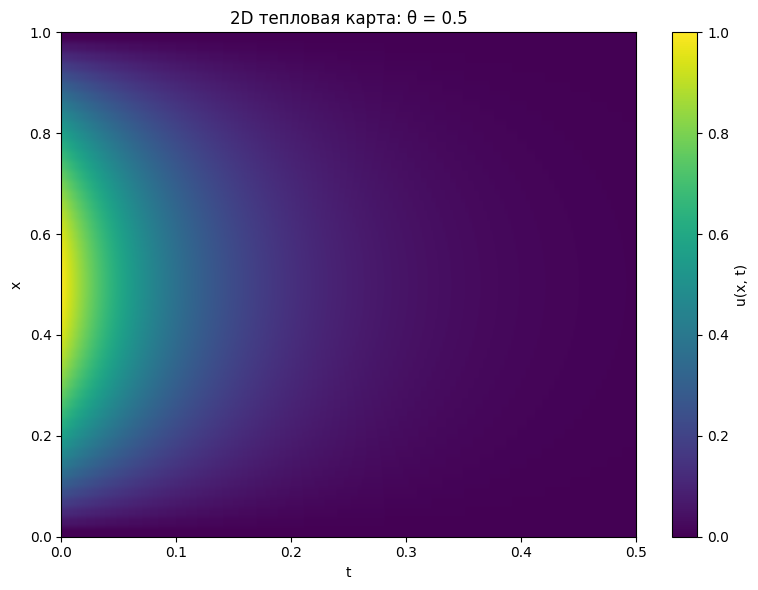

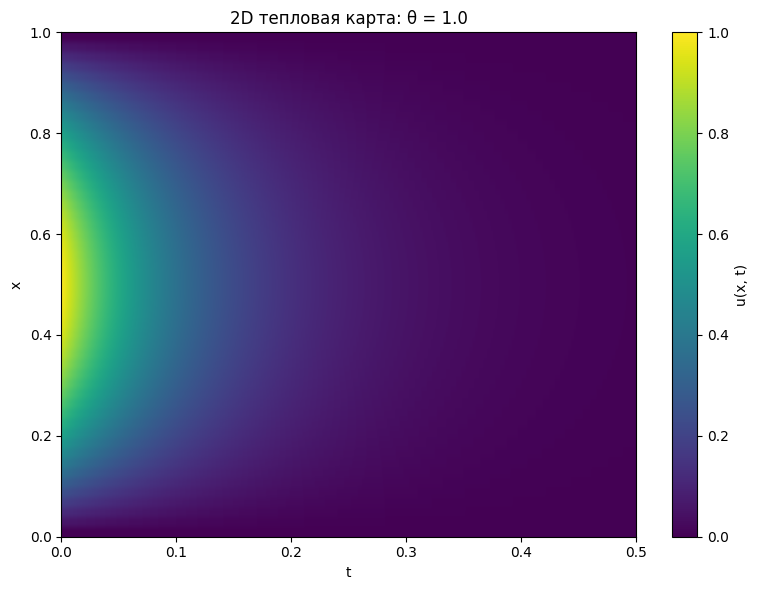

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.stats import linregress

# === Аналитическое решение ===
def analytical_solution(alpha, x, t):
    return np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * t)

# === Решение уравнения переноса методом theta-схемы ===
def solve_transport_equation(alpha, Nx, Nt, theta):
    L, T = 1.0, 0.5
    dx = L / Nx

    if theta == 0.0:
        dt_max = 0.45 * dx**2 / alpha
        dt = min(T / Nt, dt_max)  
        Nt = int(T / dt)
        dt = T / Nt  
    else:
        dt = T / Nt

    r = alpha * dt / dx**2

    x = np.linspace(0, L, Nx + 1)
    t = np.linspace(0, T, Nt + 1)

    u = np.zeros((Nx + 1, Nt + 1))
    u[:, 0] = np.sin(np.pi * x)

    A = np.zeros((Nx - 1, Nx - 1))
    B = np.zeros((Nx - 1, Nx - 1))

    for i in range(Nx - 1):
        A[i, i] = 1 + 2 * r * theta
        B[i, i] = 1 - 2 * r * (1 - theta)
        if i > 0:
            A[i, i - 1] = -r * theta
            B[i, i - 1] = r * (1 - theta)
        if i < Nx - 2:
            A[i, i + 1] = -r * theta
            B[i, i + 1] = r * (1 - theta)

    for n in range(Nt):
        b = B @ u[1:-1, n]
        u[1:-1, n + 1] = solve(A, b)

    return u, x, t


# === Построение профилей решений для разных theta ===
def plot_solutions_for_thetas(alpha, thetas, Nx=50, Nt=1000):
    x = np.linspace(0, 1, Nx + 1)
    t_indices = [0, Nt // 4, Nt // 2, Nt]

    fig, axes = plt.subplots(len(thetas), 1, figsize=(10, 4 * len(thetas)))
    if len(thetas) == 1:
        axes = [axes]

    for idx, theta in enumerate(thetas):
        u_num, x, t = solve_transport_equation(alpha, Nx, Nt, theta)
        for t_idx in t_indices:
            u_exact = analytical_solution(alpha, x, t[t_idx])
            axes[idx].plot(x, u_num[:, t_idx], label=f'Числ. t={t[t_idx]:.2f}')
            axes[idx].plot(x, u_exact, '--', label=f'Аналит. t={t[t_idx]:.2f}')
        axes[idx].set_title(f'θ = {theta}: решение в разные моменты времени')
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('u(x, t)')
        axes[idx].legend()
        axes[idx].grid()

    plt.tight_layout()
    plt.savefig('solution_profiles.png')
    plt.show()

# === Оценка порядка аппроксимации по dx и dt ===
def calculate_order_theta(alpha, thetas):
    fig, axes = plt.subplots(len(thetas), 2, figsize=(14, 5 * len(thetas)))
    if len(thetas) == 1:
        axes = np.array([axes])

    for idx, theta in enumerate(thetas):
        Nx_values = [10, 20, 40, 80]
        if theta == 0.0:
            dt_values = [0.45 * (1.0 / Nx)**2 / alpha for Nx in Nx_values]
        elif theta == 0.5:
            dt_values = [0.025, 0.0125, 0.00625, 0.003125]
        else:
            dt_values = [0.0025, 0.0003125, 0.00015625, 0.000078125]

        Nt_values = [int(0.5 / dt) for dt in dt_values]
        dx_values = [1.0 / Nx for Nx in Nx_values]
        error_norms = []

        for Nx, Nt in zip(Nx_values, Nt_values):
            u_num, x, t = solve_transport_equation(alpha, Nx, Nt, theta)
            u_exact_T = analytical_solution(alpha, x, 0.5)
            error = np.abs(u_exact_T - u_num[:, -1])
            error_norms.append(np.max(error))

        log_dx = np.log(dx_values)
        log_dt = np.log(0.5 / np.array(Nt_values))
        log_err = np.log(error_norms)

        slope_dx, intercept_dx, *_ = linregress(log_dx, log_err)
        slope_dt, intercept_dt, *_ = linregress(log_dt, log_err)

        axes[idx, 0].plot(log_dx, log_err, 'o-', label=f'Порядок x: {slope_dx:.2f}')
        axes[idx, 0].plot(log_dx, slope_dx * log_dx + intercept_dx, '--')
        axes[idx, 0].set_title(f'θ = {theta} — Порядок по x')
        axes[idx, 0].set_xlabel('log(dx)')
        axes[idx, 0].set_ylabel('log(ошибка)')
        axes[idx, 0].legend()
        axes[idx, 0].grid()

        axes[idx, 1].plot(log_dt, log_err, 'o-', label=f'Порядок t: {slope_dt:.2f}')
        axes[idx, 1].plot(log_dt, slope_dt * log_dt + intercept_dt, '--')
        axes[idx, 1].set_title(f'θ = {theta} — Порядок по t')
        axes[idx, 1].set_xlabel('log(dt)')
        axes[idx, 1].set_ylabel('log(ошибка)')
        axes[idx, 1].legend()
        axes[idx, 1].grid()

        print(f"θ = {theta}: порядок по x = {slope_dx:.2f}, порядок по t = {slope_dt:.2f}")

    # plt.tight_layout()
    # plt.savefig('order_analysis.png')
    # plt.show()

# === Построение тепловой карты решения u(x, t) ===
def plot_heatmap(u, x, t, theta):
    u = np.nan_to_num(u, nan=0.0, posinf=0.0, neginf=0.0)
    plt.figure(figsize=(8, 6))
    plt.imshow(u, aspect='auto', origin='lower',
               extent=[t[0], t[-1], x[0], x[-1]], cmap='viridis')
    plt.colorbar(label='u(x, t)')
    plt.title(f'2D тепловая карта: θ = {theta}')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.tight_layout()
    plt.savefig(f'heatmap_theta_{theta}.png')
    plt.show()

# === Основной блок ===
if __name__ == "__main__":
    thetas = [0.0, 0.5, 1.0]
    alpha = 1.0

    calculate_order_theta(alpha, thetas)
    # plot_solutions_for_thetas(alpha, thetas, Nx=50, Nt=10000)

    for theta in thetas:
        Nt = 2000 if theta != 0.0 else 100  # для явной схемы стабильный шаг
        u, x, t = solve_transport_equation(alpha, Nx=50, Nt=Nt, theta=theta)
        plot_heatmap(u, x, t, theta)